## Linear Bandits UCB 

In [1]:
import math
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('data/warfarin.csv')
data = data[data['Therapeutic Dose of Warfarin'].notnull()]

In [3]:
data = data.reset_index(drop=True) # fix weird row indexing 

In [4]:
def assign_bucket(n):
    if n < 21:
        return 0
    elif n > 49:
        return 2
    else:
        return 1


In [5]:
def create_feature_vec(row):
    x = np.zeros([8,1])
    index = row.index[0]
    
    # Age 
    age =  row.loc[index, 'Age']
    if type(age) != float:
        x[0] = int(age[0])
    
    # Height 
    height = row.loc[index,'Height (cm)']
    if not math.isnan(height):
        x[1] = height
    
    # Weight 
    weight = row.loc[index,'Weight (kg)']
    if not math.isnan(weight):
        x[2] = weight 
    
    race = row.loc[index,'Race']
    # Race
    if race == 'Asian':
        x[3] = 1
    if race == 'Black or African American':
        x[4] = 1
    if race == 'Unknown':
        x[5] = 1

    # enzyme inducer 
    carbamazepine = int(row.loc[index,'Carbamazepine (Tegretol)']) if not math.isnan(row.loc[index,'Carbamazepine (Tegretol)']) else 0
    phenytoin = int(row.loc[index,'Phenytoin (Dilantin)']) if not math.isnan(row.loc[index,'Phenytoin (Dilantin)']) else 0
    rifampin = int(row.loc[index,'Rifampin or Rifampicin']) if not math.isnan(row.loc[index,'Rifampin or Rifampicin']) else 0

    if carbamazepine or phenytoin or rifampin:
        x[6] = 1
    
    # amiodarone 
    amiodarone = int(row.loc[index,'Amiodarone (Cordarone)']) if not math.isnan(row.loc[index,'Amiodarone (Cordarone)']) else 0
    if amiodarone: 
        x[7] = 1
    
    return x



In [13]:
def new_create_feature_vec(row):
    x = np.zeros([17,1])
    index = row.index[0]
    
    # Age 
    age =  row.loc[index, 'Age']
    if type(age) != float:
        x[0] = int(age[0])
    
    # Height 
    height = row.loc[index,'Height (cm)']
    if not math.isnan(height):
        x[1] = height
    
    # Weight 
    weight = row.loc[index,'Weight (kg)']
    if not math.isnan(weight):
        x[2] = weight 

    # VKORC1 
    vkorc1_ag = row.loc[index, 'VKORC1 genotype: -1639 G>A (3673); chr16:31015190; rs9923231; C/T']
    if type(vkorc1_ag) != float:
        if vkorc1_ag == 'A/G':
            x[3] = 1
        if vkorc1_ag == 'A/A':
            x[4] = 1
        if vkorc1_ag == 'NA':
            x[5] = 1
    
    # CYP2C9 
    cyp2c9 = row.loc[index, 'Cyp2C9 genotypes']
    if type(cyp2c9) != float:
        if cyp2c9 == '*1/*2':
            x[6] = 1
        if cyp2c9 == '*1/*3':
            x[7] = 1
        if cyp2c9 == '*2/*2':
            x[8] = 1
        if cyp2c9 == '*2/*3':
            x[9] = 1
        if cyp2c9 == '*3/*3':
            x[10] = 1
        if cyp2c9 == 'NA':
            x[11] = 1
    
    race = row.loc[index,'Race']
    # Race
    if race == 'Asian':
        x[12] = 1
    if race == 'Black or African American':
        x[13] = 1
    if race == 'Unknown':
        x[14] = 1

    # enzyme inducer 
    carbamazepine = int(row.loc[index,'Carbamazepine (Tegretol)']) if not math.isnan(row.loc[index,'Carbamazepine (Tegretol)']) else 0
    phenytoin = int(row.loc[index,'Phenytoin (Dilantin)']) if not math.isnan(row.loc[index,'Phenytoin (Dilantin)']) else 0
    rifampin = int(row.loc[index,'Rifampin or Rifampicin']) if not math.isnan(row.loc[index,'Rifampin or Rifampicin']) else 0

    if carbamazepine or phenytoin or rifampin:
        x[15] = 1
    
    # amiodarone 
    amiodarone = int(row.loc[index,'Amiodarone (Cordarone)']) if not math.isnan(row.loc[index,'Amiodarone (Cordarone)']) else 0
    if amiodarone: 
        x[16] = 1
    
    return x



In [6]:
doses = data['Therapeutic Dose of Warfarin']
doses = doses.apply(lambda dose : assign_bucket(dose)).to_numpy()
print(len(doses))
print(len(data))

5528
5528


In [14]:
sum_of_r = 0
T = len(data)
d = 17
alpha = 1
num_a = 3
A_list = [np.identity(d), np.identity(d), np.identity(d)]
b_list = [np.zeros([d,1]), np.zeros([d,1]), np.zeros([d,1])]

linUCB_doses = np.zeros(T)

# online sampling
for t in range(T):
    row = data.sample(replace=False)
    # row = data.loc[[t]]

    x = new_create_feature_vec(row)

    p = np.zeros(3)
    for a in range(num_a):
        A = A_list[a]
        b = b_list[a]
        A_inv = np.linalg.inv(A)
        theta = A_inv @ b
        p[a] = theta.T @ x + alpha * np.sqrt(x.T @ A_inv @ x)
    
    best_a = np.argmax(p)
    linUCB_doses[row.index[0]] = best_a

    correct_dose = doses[row.index[0]]

    if best_a == correct_dose: 
        r = 0 
    else: r = -1
    sum_of_r += r

    A_list[best_a] = A_list[best_a] + x @ x.T
    b_list[best_a] = b_list[best_a] + r * x


KeyError: 'rs9923231'

In [12]:

print(f"Performance of linUCB: {round(abs(sum_of_r) / len(doses), 4)}")


Performance of linUCB: 0.3904


In [9]:
l = []
for i in range(1, len(doses)):
    num_wrong = np.count_nonzero(doses[:i] - linUCB_doses[:i])
    f = num_wrong / i
    l.append(f)


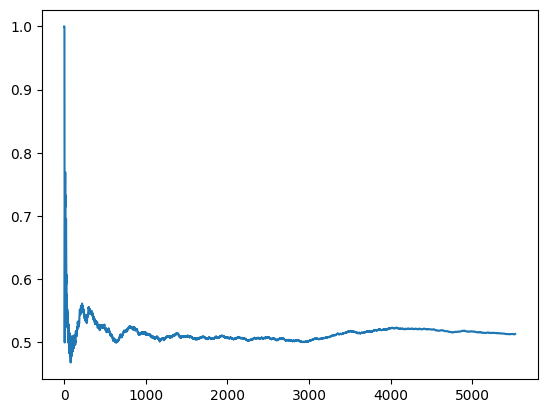

In [10]:
import matplotlib.pyplot as plt
plt.plot(l)